In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from utils import *

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

In [3]:
train.head()

,id,location,fault_severity,event_type 1,event_type 10,event_type 11,event_type 12,event_type 13,event_type 14,event_type 15,...,feature 90 volume,feature 91 volume,feature 92 volume,feature 93 volume,feature 94 volume,feature 95 volume,feature 96 volume,feature 97 volume,feature 98 volume,feature 99 volume
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8218,location 931,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,14804,location 120,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sample = pd.read_csv('sample_submission.csv')

In [5]:
sess = tf.InteractiveSession()

In [6]:
batch_size = 10

In [50]:
insample_evaluates = []
outsample_evaluates = []
com_cats = []
for rid, com_range in enumerate(full_ranges[1:]):
    print(rid)
    col_ids = list_sum(x[1] for x in com_range)
    com_cat = string_sum(x[0] for x in com_range)
    x = tf.placeholder('float', shape=[None, len(col_ids)])
    y_ = tf.placeholder('float', shape=[None, 3])
    l2 = tf.placeholder('float')
    hidden1 = 2000
    hidden2 = 100
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([len(col_ids), hidden1],
                                stddev=1.0 / np.sqrt(float(len(col_ids)))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1]),
                             name='biases')
        hidden1_tensor = tf.nn.relu(tf.matmul(x, weights) + biases)
        reg_hidden1 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1, hidden2],
                                stddev=1.0 / np.sqrt(float(hidden1))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2]),
                             name='biases')
        hidden2_tensor = tf.nn.relu(tf.matmul(hidden1_tensor, weights) + biases)
        reg_hidden2 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2, 3],
                                stddev=1.0 / np.sqrt(float(hidden2))),
            name='weights')
        biases = tf.Variable(tf.zeros([3]),
                             name='biases')
        logits = tf.matmul(hidden2_tensor, weights) + biases
        reg_hidden3 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    sess.run(tf.initialize_all_variables()) 
    y = tf.nn.softmax(logits)
    cross_entropy = - tf.reduce_mean(y_ * tf.log(y) + 1e-15) + l2 * (reg_hidden1 + reg_hidden2 + reg_hidden3)
    train_step = tf.train.GradientDescentOptimizer(.001).minimize(cross_entropy)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, col_ids],
        train.loc[:, 'fault_severity'],
        test_size=0.3333,
        random_state=100383)
    labels = tf.expand_dims(np.asarray(train_y.values, dtype='int32'), 1)
    indices = tf.expand_dims(tf.range(0, train_x.shape[0]), 1)
    concated = tf.concat(1, [indices, labels])
    train_onehot_labels = tf.sparse_to_dense(
        concated, tf.pack([train_x.shape[0], sample.shape[1]-1]), 1.0, 0.0).eval()
    for i in range(train_x.shape[0]//batch_size):
        train_step.run(
            feed_dict={
                x: train_x.iloc[batch_size*i:batch_size*(i+1), :].values,
                y_: train_onehot_labels[batch_size*i:batch_size*(i+1), :],
                l2: 0})
    labels = tf.expand_dims(np.asarray(valid_y.values, dtype='int32'), 1)
    indices = tf.expand_dims(tf.range(0, valid_x.shape[0]), 1)
    concated = tf.concat(1, [indices, labels])
    valid_onehot_labels = tf.sparse_to_dense(
        concated, tf.pack([valid_x.shape[0], sample.shape[1]-1]), 1.0, 0.0).eval()
    evaluate = - tf.reduce_mean(tf.reduce_sum(y_ * tf.log(y), 1))
    insample_evaluate = evaluate.eval(feed_dict={x: train_x, y_: train_onehot_labels})
    insample_evaluates.append(insample_evaluate)
    outsample_evaluate = evaluate.eval(feed_dict={x: valid_x, y_: valid_onehot_labels})
    outsample_evaluates.append(outsample_evaluate)
    com_cats.append(com_cat)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=com_cats)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


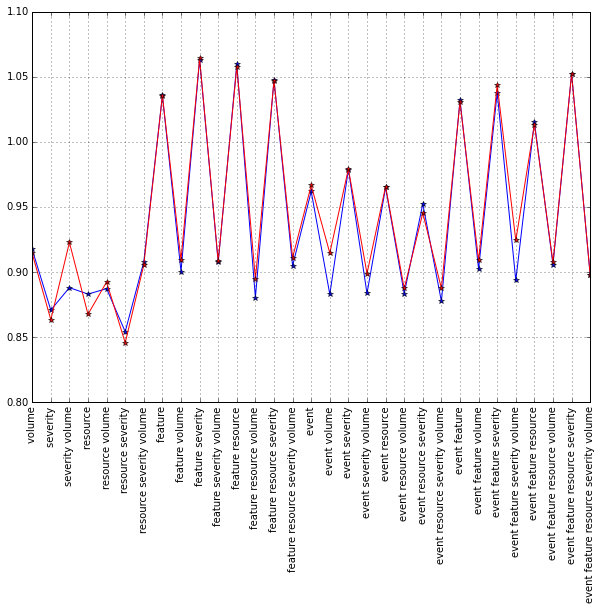

In [49]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

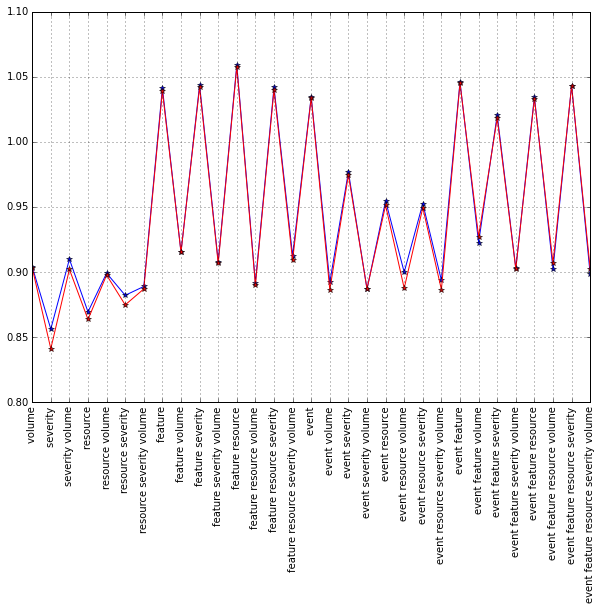

In [51]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
res.loc[:, 'insample_evaluates'].plot(kind='line', ax=ax, rot=90, marker='*')
res.loc[:, 'outsample_evaluates'].plot(kind='line', ax=ax, color='r', rot=90, marker='*')
plt.xticks(range(len(res.index)), res.index)
plt.grid()
plt.show()

In [59]:
insample_evaluates = []
outsample_evaluates = []
regs = [0.01, .1, .2, .3, .4]
for rid, reg in enumerate(regs):
    print(rid)
    col_ids = list_sum(x[1] for x in ranges[2:4])
    x = tf.placeholder('float', shape=[None, len(col_ids)])
    y_ = tf.placeholder('float', shape=[None, 3])
    l2 = tf.placeholder('float')
    hidden1 = 2000
    hidden2 = 100
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([len(col_ids), hidden1],
                                stddev=1.0 / np.sqrt(float(len(col_ids)))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1]),
                             name='biases')
        hidden1_tensor = tf.nn.relu(tf.matmul(x, weights) + biases)
        reg_hidden1 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1, hidden2],
                                stddev=1.0 / np.sqrt(float(hidden1))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2]),
                             name='biases')
        hidden2_tensor = tf.nn.relu(tf.matmul(hidden1_tensor, weights) + biases)
        reg_hidden2 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2, 3],
                                stddev=1.0 / np.sqrt(float(hidden2))),
            name='weights')
        biases = tf.Variable(tf.zeros([3]),
                             name='biases')
        logits = tf.matmul(hidden2_tensor, weights) + biases
        reg_hidden3 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
    sess.run(tf.initialize_all_variables()) 
    y = tf.nn.softmax(logits)
    cross_entropy = - tf.reduce_mean(y_ * tf.log(y) + 1e-15) + l2 * (reg_hidden1 + reg_hidden2 + reg_hidden3)
    train_step = tf.train.GradientDescentOptimizer(.001).minimize(cross_entropy)
    train_x, valid_x, train_y, valid_y = train_test_split(
        train.iloc[:, col_ids],
        train.loc[:, 'fault_severity'],
        test_size=0.3333)
    labels = tf.expand_dims(np.asarray(train_y.values, dtype='int32'), 1)
    indices = tf.expand_dims(tf.range(0, train_x.shape[0]), 1)
    concated = tf.concat(1, [indices, labels])
    train_onehot_labels = tf.sparse_to_dense(
        concated, tf.pack([train_x.shape[0], sample.shape[1]-1]), 1.0, 0.0).eval()
    for i in range(train_x.shape[0]//batch_size):
        train_step.run(
            feed_dict={
                x: train_x.iloc[batch_size*i:batch_size*(i+1), :].values,
                y_: train_onehot_labels[batch_size*i:batch_size*(i+1), :],
                l2: 0})
    labels = tf.expand_dims(np.asarray(valid_y.values, dtype='int32'), 1)
    indices = tf.expand_dims(tf.range(0, valid_x.shape[0]), 1)
    concated = tf.concat(1, [indices, labels])
    valid_onehot_labels = tf.sparse_to_dense(
        concated, tf.pack([valid_x.shape[0], sample.shape[1]-1]), 1.0, 0.0).eval()
    evaluate = - tf.reduce_mean(tf.reduce_sum(y_ * tf.log(y), 1))
    insample_evaluate = evaluate.eval(feed_dict={x: train_x, y_: train_onehot_labels})
    insample_evaluates.append(insample_evaluate)
    outsample_evaluate = evaluate.eval(feed_dict={x: valid_x, y_: valid_onehot_labels})
    outsample_evaluates.append(outsample_evaluate)
res = pd.DataFrame(
    {'insample_evaluates': insample_evaluates,
     'outsample_evaluates': outsample_evaluates}, index=regs)

0
1
2
3
4


In [60]:
res

,insample_evaluates,outsample_evaluates
0.01,0.861424,0.852563
0.10,0.838672,0.838665
0.20,0.900796,0.907573
0.30,0.849026,0.849778
0.40,0.853159,0.861424


In [58]:
res

,insample_evaluates,outsample_evaluates
0.0,0.859897,0.858267
0.1,0.834943,0.833401
0.5,0.857381,0.851656
1.0,0.863357,0.859290
5.0,0.862304,0.853410
10.0,0.848782,0.851556
50.0,0.902761,0.887449


In [61]:
col_ids = list_sum(x[1] for x in ranges[2:4])
x = tf.placeholder('float', shape=[None, len(col_ids)])
y_ = tf.placeholder('float', shape=[None, 3])
l2 = tf.placeholder('float')
hidden1 = 2000
hidden2 = 100
with tf.name_scope('hidden1'):
    weights = tf.Variable(
        tf.truncated_normal([len(col_ids), hidden1],
                            stddev=1.0 / np.sqrt(float(len(col_ids)))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden1]),
                         name='biases')
    hidden1_tensor = tf.nn.relu(tf.matmul(x, weights) + biases)
    reg_hidden1 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
with tf.name_scope('hidden2'):
    weights = tf.Variable(
        tf.truncated_normal([hidden1, hidden2],
                            stddev=1.0 / np.sqrt(float(hidden1))),
        name='weights')
    biases = tf.Variable(tf.zeros([hidden2]),
                         name='biases')
    hidden2_tensor = tf.nn.relu(tf.matmul(hidden1_tensor, weights) + biases)
    reg_hidden2 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
with tf.name_scope('softmax_linear'):
    weights = tf.Variable(
        tf.truncated_normal([hidden2, 3],
                            stddev=1.0 / np.sqrt(float(hidden2))),
        name='weights')
    biases = tf.Variable(tf.zeros([3]),
                         name='biases')
    logits = tf.matmul(hidden2_tensor, weights) + biases
    reg_hidden3 = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
sess.run(tf.initialize_all_variables()) 
y = tf.nn.softmax(logits)
cross_entropy = - tf.reduce_mean(y_ * tf.log(y) + 1e-15) + l2 * (reg_hidden1 + reg_hidden2 + reg_hidden3)
train_step = tf.train.GradientDescentOptimizer(.001).minimize(cross_entropy)
labels = tf.expand_dims(np.asarray(train.loc[:, 'fault_severity'].values, dtype='int32'), 1)
indices = tf.expand_dims(tf.range(0, train.shape[0]), 1)
concated = tf.concat(1, [indices, labels])
train_onehot_labels = tf.sparse_to_dense(
    concated, tf.pack([train.shape[0], sample.shape[1]-1]), 1.0, 0.0).eval()
for i in range(train_x.shape[0]//batch_size):
    train_step.run(
        feed_dict={
            x: train.iloc[batch_size*i:batch_size*(i+1), col_ids].values,
            y_: train_onehot_labels[batch_size*i:batch_size*(i+1), :],
            l2: 0.1})

In [62]:
test_ranges = [
    ('resource', range(test_resource_start, test_severity_start)),
    ('severity', range(test_severity_start, test_volume_start))]

In [63]:
test_col_ids = list_sum(x[1] for x in test_ranges)

In [64]:
prob = y.eval(feed_dict={x: test.iloc[:, test_col_ids]})

In [65]:
prob.shape

(11171, 3)

In [66]:
nn = pd.DataFrame({
    'id': sample.loc[:, 'id'].values, 
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

In [67]:
nn.head()

,id,predict_0,predict_1,predict_2
0,11066,0.609336,0.242824,0.147840
1,18000,0.509575,0.316799,0.173626
2,16964,0.609336,0.242824,0.147840
3,4795,0.436521,0.352126,0.211352
4,3392,0.543785,0.280022,0.176193


In [68]:
nn.to_csv('neural_network.csv', index=False)